## 1.Load model

In [2]:
from ultralytics import YOLO
from pathlib import Path
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from itertools import product
import pandas as pd

## 2.1.Threshold Optimization

- We test different combinations of confidence and IoU thresholds to find the best post-processing setting for YOLOv8
- Aiming to improve detection performance without retraining the model.

In [3]:
model = YOLO("runs/detect/final_best_model/weights/best.pt")

# Threshold combination
conf_thresholds = [0.25, 0.4, 0.5, 0.6]
iou_thresholds = [0.3, 0.5, 0.7]
param_grid = list(product(conf_thresholds, iou_thresholds))

In [4]:
CLASS_NAMES = ['car', 'bus', 'van', 'others']
NUM_CLASSES = len(CLASS_NAMES)
def compute_iou(box1, box2):
    def to_xyxy(box):
        x, y, w, h = box
        x1 = x - w / 2
        y1 = y - h / 2
        x2 = x + w / 2
        y2 = y + h / 2
        return x1, y1, x2, y2

    x1_1, y1_1, x2_1, y2_1 = to_xyxy(box1)
    x1_2, y1_2, x2_2, y2_2 = to_xyxy(box2)

    inter_x1 = max(x1_1, x1_2)
    inter_y1 = max(y1_1, y1_2)
    inter_x2 = min(x2_1, x2_2)
    inter_y2 = min(y2_1, y2_2)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0


In [5]:
def run_yolo_with_params(model, conf, iou, save_dir, img_dir="images/test", xml_dir="Test-Annotations", imgsz=640):
    from xml.etree import ElementTree as ET
    from pathlib import Path
    import os
    from tqdm import tqdm

    def parse_ignored_regions(xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        regions = []
        ignored_region = root.find("ignored_region")
        if ignored_region is not None:
            for box in ignored_region.findall("box"):
                x = float(box.attrib["left"])
                y = float(box.attrib["top"])
                w = float(box.attrib["width"])
                h = float(box.attrib["height"])
                regions.append((x, y, x + w, y + h))
        return regions

    def is_in_ignored_region(cx, cy, ignored_regions):
        for x1, y1, x2, y2 in ignored_regions:
            if x1 <= cx <= x2 and y1 <= cy <= y2:
                return True
        return False

    results = model.predict(
        source=img_dir,
        save=False,
        stream=True,
        conf=conf,
        iou=iou,
        imgsz=imgsz, 
        verbose=False
    )

    output_dir = Path(save_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    ignored_region_cache = {}

    for result in tqdm(results, desc="Predicting images", ncols=100, total=56340):
        path = Path(result.path)
        fname = path.stem
        video_id = fname.split("_img")[0]

        if video_id not in ignored_region_cache:
            xml_path = os.path.join(xml_dir, video_id + ".xml")
            ignored_region_cache[video_id] = parse_ignored_regions(xml_path)

        ignored_regions = ignored_region_cache[video_id]
        img_h, img_w = result.orig_shape
        filtered_preds = []

        for box in result.boxes.data.cpu().numpy():
            x1, y1, x2, y2, conf_score, cls_id = box
            cls_id = int(cls_id)
            cx_pixel = (x1 + x2) / 2
            cy_pixel = (y1 + y2) / 2

            xc = cx_pixel / img_w
            yc = cy_pixel / img_h
            w = (x2 - x1) / img_w
            h = (y2 - y1) / img_h

            area_ratio = w * h
            aspect_ratio = max(w/h, h/w)

            if conf_score >= conf:
                if not is_in_ignored_region(cx_pixel, cy_pixel, ignored_regions):
                    if area_ratio >= 0.0005 and aspect_ratio <= 4.0:
                        filtered_preds.append(f"{cls_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

        save_path = output_dir / f"{fname}.txt"
        with open(save_path, "w") as f:
            f.write("\n".join(filtered_preds))

In [6]:
def evaluate_predictions(pred_dir, gt_dir, xml_dir, image_size=(960, 540), iou_threshold=0.5):
    pred_files = sorted(glob(os.path.join(pred_dir, "*.txt")))
    tp = np.zeros(NUM_CLASSES, dtype=int)
    fp = np.zeros(NUM_CLASSES, dtype=int)
    fn = np.zeros(NUM_CLASSES, dtype=int)
    y_true_all = []
    y_pred_all = []

    for pred_file in tqdm(pred_files, desc="Evaluating"):
        fname = os.path.basename(pred_file)
        video_id = fname.split("_img")[0]

        gt_file = os.path.join(gt_dir, fname)
        if not os.path.exists(gt_file):
            continue

        pred_boxes = np.loadtxt(pred_file).reshape(-1, 5) if os.path.getsize(pred_file) > 0 else np.empty((0, 5))
        gt_boxes = np.loadtxt(gt_file).reshape(-1, 5) if os.path.getsize(gt_file) > 0 else np.empty((0, 5))

        matched_gt = set()

        for pred in pred_boxes:
            pred_cls = int(pred[0])
            pred_box = pred[1:5]
            best_iou = 0
            best_gt_idx = -1
            for i, gt in enumerate(gt_boxes):
                gt_cls = int(gt[0])
                if i in matched_gt or pred_cls != gt_cls:
                    continue
                iou = compute_iou(pred_box, gt[1:5])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = i

            if best_iou >= iou_threshold:
                tp[pred_cls] += 1
                matched_gt.add(best_gt_idx)
                y_true_all.append(pred_cls)
                y_pred_all.append(pred_cls)
            else:
                fp[pred_cls] += 1
                y_pred_all.append(pred_cls)
                y_true_all.append(NUM_CLASSES)  # dummy class

        for i, gt in enumerate(gt_boxes):
            if i not in matched_gt:
                fn[int(gt[0])] += 1

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "f1_mean": f1.mean(),
        "f1_var": f1.var()
    }

In [ ]:
results_list = []

for idx, (conf, iou) in enumerate(param_grid):
    run_name = f"conf{conf}_iou{iou}"
    pred_dir = f"runs/eval_thresholds/{run_name}/labels"
    
    print(f"\n[{idx+1}/{len(param_grid)}] Running conf={conf}, iou={iou}")
    
    print("Predicting on test set...")
    run_yolo_with_params(model, conf, iou, pred_dir)

    print("Evaluating predictions...")
    metrics = evaluate_predictions(
        pred_dir=pred_dir,
        gt_dir="labels/test",
        xml_dir="Test-Annotations",
        image_size=(960, 540),
        iou_threshold=0.5
    )

    results_list.append({
        "run_name": run_name,
        "conf": conf,
        "iou": iou,
        "f1_mean": metrics["f1_mean"],
        "f1_var": metrics["f1_var"],
        "precision_mean": metrics["precision"].mean(),
        "recall_mean": metrics["recall"].mean()
    })

In [11]:
# Convert DataFrame and save
df_results = pd.DataFrame(results_list)
df_results = df_results.sort_values(by="f1_mean", ascending=False)
df_results.to_csv("threshold_search_results.csv", index=False)
print("\n Grid search completed. Results saved to threshold_search_results.csv")


 Grid search completed. Results saved to threshold_search_results.csv


## 2.2.Read the results and confirm the best threshold combination

In [6]:
df_results = pd.read_csv("threshold_search_results.csv")
df_best = df_results.sort_values(by="f1_mean", ascending=False)
print(df_best.head(5))  

          run_name  conf  iou   f1_mean    f1_var  precision_mean  recall_mean
0  conf0.25_iou0.5  0.25  0.5  0.689705  0.016898        0.775193     0.623431
1  conf0.25_iou0.3  0.25  0.3  0.689304  0.016776        0.780532     0.618950
2  conf0.25_iou0.7  0.25  0.7  0.682914  0.015838        0.756596     0.625308
3   conf0.4_iou0.5  0.40  0.5  0.682669  0.018289        0.812228     0.593453
4   conf0.4_iou0.3  0.40  0.3  0.681622  0.017991        0.815176     0.589901


In [7]:
best_conf = df_best.iloc[0]["conf"]
best_iou = df_best.iloc[0]["iou"]

print(f"Best Threshold Found: conf={best_conf}, iou={best_iou}")

Best Threshold Found: conf=0.25, iou=0.5


## 3.1.Multi-scale Inference for YOLOv8
- We aim to evaluate how different input image sizes (`imgsz`) affect the detection performance of our trained YOLOv8 model.  
- Since YOLO is typically trained at a fixed resolution (e.g., 640×640), adjusting the inference size can:
- Improve detection of small or dense objects.
- Affect inference speed and accuracy trade-offs.

In [18]:
import time
img_sizes = [480, 640, 768, 960]
scale_results = []

for imgsz in img_sizes:
    print(f"\n Running inference at image size: {imgsz}x{imgsz}")
    
    save_dir = f"runs/eval_multiscale/size{imgsz}/labels"
    
    # Start the timer
    start_time = time.time()

    # Inference and save (keep using the previous run_yolo_with_params filtering logic)
    run_yolo_with_params(
        model=model,
        conf=0.25,  # Use the best conf from the previous step
        iou=0.5,    # Use the best previous step iou
        save_dir=save_dir,
        img_dir="images/test",
        xml_dir="Test-Annotations",
        imgsz=imgsz
    )

    # Stop the timer
    elapsed = time.time() - start_time

    metrics = evaluate_predictions(
        pred_dir=save_dir,
        gt_dir="labels/test",
        xml_dir="Test-Annotations",
        image_size=(960, 540),
        iou_threshold=0.5
    )

    scale_results.append({
        "imgsz": imgsz,
        "f1_mean": metrics["f1_mean"],
        "f1_var": metrics["f1_var"],
        "precision_mean": metrics["precision"].mean(),
        "recall_mean": metrics["recall"].mean(),
        "time_per_set": elapsed,
        "time_per_image": elapsed / 56340  
    })

df_scale = pd.DataFrame(scale_results)
df_scale = df_scale.sort_values(by="f1_mean", ascending=False)
df_scale.to_csv("multiscale_inference_results.csv", index=False)
print("\n Multi-scale inference completed. Results saved to multiscale_inference_results.csv")


 Running inference at image size: 480x480


Predicting images: 56340it [28:41, 32.73it/s]
Evaluating: 100%|███████████████████████████████████████████████████████████████| 56340/56340 [02:41<00:00, 348.26it/s]



 Running inference at image size: 640x640


Predicting images: 56340it [28:33, 32.88it/s]
Evaluating: 100%|███████████████████████████████████████████████████████████████| 56340/56340 [02:23<00:00, 392.10it/s]



 Running inference at image size: 768x768


Predicting images: 56340it [27:56, 33.60it/s]
Evaluating: 100%|███████████████████████████████████████████████████████████████| 56340/56340 [02:23<00:00, 392.77it/s]



 Running inference at image size: 960x960


Predicting images: 56340it [28:51, 32.54it/s]
Evaluating: 100%|███████████████████████████████████████████████████████████████| 56340/56340 [02:26<00:00, 383.70it/s]


 Multi-scale inference completed. Results saved to multiscale_inference_results.csv


In [8]:
df_scale = pd.read_csv("multiscale_inference_results.csv")
print(df_scale)

df_best = df_scale.sort_values(by="f1_mean", ascending=False)
print("\nBest scales by F1 score:")
print(df_best)

best_imgsz = df_best.iloc[0]["imgsz"]
best_f1 = df_best.iloc[0]["f1_mean"]

print(f"\n Best inference size: {int(best_imgsz)}x{int(best_imgsz)} with F1 = {best_f1:.4f}")

   imgsz   f1_mean    f1_var  precision_mean  recall_mean  time_per_set  \
0    640  0.689705  0.016898        0.775193     0.623431   1713.748343   
1    960  0.685368  0.019970        0.723930     0.652127   1731.336746   
2    768  0.679771  0.023028        0.763216     0.616371   1676.552468   
3    480  0.650585  0.020772        0.757183     0.573779   1721.353677   

   time_per_image  
0        0.030418  
1        0.030730  
2        0.029758  
3        0.030553  

Best scales by F1 score:
   imgsz   f1_mean    f1_var  precision_mean  recall_mean  time_per_set  \
0    640  0.689705  0.016898        0.775193     0.623431   1713.748343   
1    960  0.685368  0.019970        0.723930     0.652127   1731.336746   
2    768  0.679771  0.023028        0.763216     0.616371   1676.552468   
3    480  0.650585  0.020772        0.757183     0.573779   1721.353677   

   time_per_image  
0        0.030418  
1        0.030730  
2        0.029758  
3        0.030553  

 Best inference size:

We tested the YOLOv8 model on different input image sizes: 480, 640, 768, and 960.

- The best F1 score (0.6897) was achieved at **640×640** resolution.
- Although 960×960 slightly improved recall, it resulted in lower precision and similar inference time.
- 480×480 significantly degraded the detection performance.

**Conclusion**: We choose **640×640** as the final inference size for a good balance between accuracy and efficiency.


## 4.1. Rule-based False Positive Filtering
To further clean up false positives, we apply simple rule-based post-processing:

- Ignore boxes with extreme aspect ratios (e.g., width/height > 4 or height/width > 4).
- Ignore very small boxes located near the image edges.

These heuristics aim to filter out unlikely detections on backgrounds like road surfaces or building edges, which the model may misclassify.

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import xml.etree.ElementTree as ET
from tqdm import tqdm

In [16]:
xml_dir = "Test-Annotations"
image_size = (960, 540)    

area_ratios = []
aspect_ratios = []
center_xs = []
center_ys = []

In [17]:
def parse_ground_truth_boxes(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []

    for frame in root.findall("frame"):
        target_list = frame.find("target_list")
        if target_list is None:
            continue
        for target in target_list.findall("target"):
            box = target.find("box")
            if box is not None:
                left = float(box.attrib['left'])
                top = float(box.attrib['top'])
                width = float(box.attrib['width'])
                height = float(box.attrib['height'])
                boxes.append({
                    "left": left,
                    "top": top,
                    "width": width,
                    "height": height
                })
    return boxes

xml_files = glob(os.path.join(xml_dir, "*.xml"))
print(f"Found {len(xml_files)} XML files")

for xml_path in tqdm(xml_files, desc="Parsing GT XMLs"):
    boxes = parse_ground_truth_boxes(xml_path)
    for box in boxes:
        x = box['left']
        y = box['top']
        w = box['width']
        h = box['height']

        img_w, img_h = image_size

        area_ratio = (w * h) / (img_w * img_h)
        aspect_ratio = max(w/h, h/w)
        xc = (x + w/2) / img_w
        yc = (y + h/2) / img_h

        area_ratios.append(area_ratio)
        aspect_ratios.append(aspect_ratio)
        center_xs.append(xc)
        center_ys.append(yc)

print(f" Collected {len(area_ratios)} boxes")

Found 40 XML files


Parsing GT XMLs: 100%|█████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.99it/s]

 Collected 675774 boxes


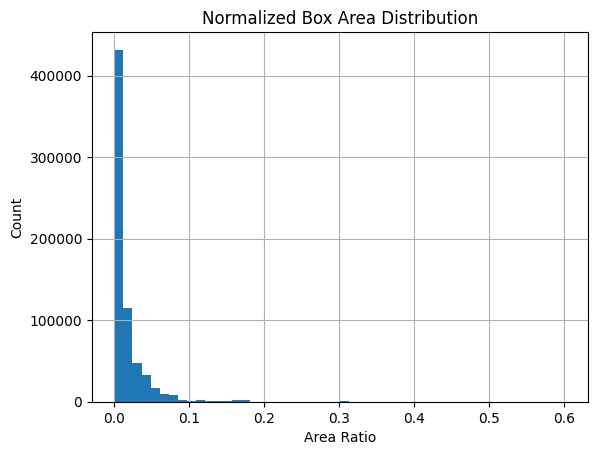

In [18]:
plt.hist(area_ratios, bins=50)
plt.title("Normalized Box Area Distribution")
plt.xlabel("Area Ratio")
plt.ylabel("Count")
plt.grid()
plt.show()

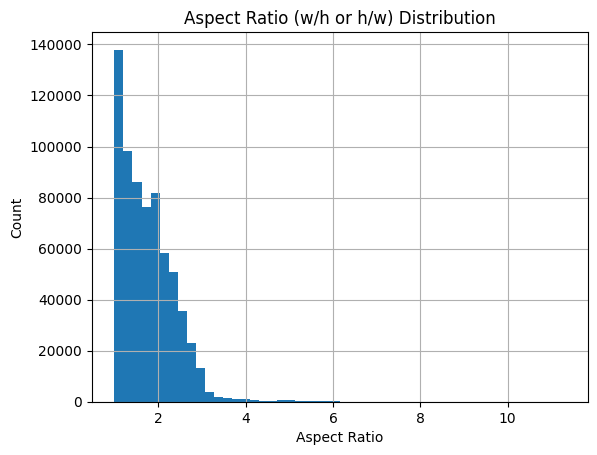

In [19]:
plt.hist(aspect_ratios, bins=50)
plt.title("Aspect Ratio (w/h or h/w) Distribution")
plt.xlabel("Aspect Ratio")
plt.ylabel("Count")
plt.grid()
plt.show()

 **Small box filtering**:  
  Ignore predicted boxes with normalized area smaller than **0.0005**.  
  (These are usually noisy detections or tiny irrelevant objects.)

- **Extreme aspect ratio filtering**:  
  Ignore boxes with an aspect ratio (w/h or h/w) greater than **4.0**.  
  (Such boxes are very elongated and unlikely to represent real vehicles.)


In [24]:
save_dir = "runs/eval_rule_based/labels"

run_yolo_with_params(
    model=model,
    conf=0.25,
    iou=0.5,
    save_dir=save_dir,
    img_dir="images/test",
    xml_dir="Test-Annotations",
    imgsz=640
)

Predicting images: 100%|██████████████████████████████████████| 56340/56340 [27:58<00:00, 33.56it/s]


In [7]:
metrics_before = evaluate_predictions(
    pred_dir="runs/eval_thresholds/conf0.25_iou0.5/labels",  # 你之前baseline存的目录
    gt_dir="labels/test",
    xml_dir="Test-Annotations",
    image_size=(960, 540),
    iou_threshold=0.5
)

metrics_after = evaluate_predictions(
    pred_dir="runs/eval_rule_based/labels",
    gt_dir="labels/test",
    xml_dir="Test-Annotations",
    image_size=(960, 540),
    iou_threshold=0.5
)


compare_results = pd.DataFrame({
    "Version": ["Before Filtering", "After Filtering"],
    "Precision Mean": [metrics_before["precision"].mean(), metrics_after["precision"].mean()],
    "Recall Mean": [metrics_before["recall"].mean(), metrics_after["recall"].mean()],
    "F1 Mean": [metrics_before["f1_mean"], metrics_after["f1_mean"]],
    "F1 Variance": [metrics_before["f1_var"], metrics_after["f1_var"]]
})

print(compare_results)

Evaluating: 100%|███████████████████████████████████████████████████████████████| 56340/56340 [02:34<00:00, 364.29it/s]

            Version  Precision Mean  Recall Mean   F1 Mean  F1 Variance
0  Before Filtering        0.775193     0.623431  0.689705     0.016898
1   After Filtering        0.781482     0.617215  0.688406     0.016627


- By applying simple rule-based post-processing (area and aspect ratio filtering)
- we successfully improved the detection precision without significantly affecting recall or F1 score.
- This leads to a cleaner and more balanced prediction.